In [1]:
import Pkg; 
Pkg.activate(@__DIR__); 
Pkg.instantiate()

  Activating environment at `~/Documents/PhD/courses/16745_optimal_control_rl/project/ballbot_ocrl_navigation/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using StaticArrays
using MeshCat
using MeshCatMechanisms
using ForwardDiff
using Plots
using RobotDynamics
using Ipopt
using FileIO, JLD2
using Colors

import Random
import ECOS
import Convex as cvx
import MathOptInterface as MOI
import MeshCat as mc;

WebIO._IJuliaInit()

In [54]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","ballbot_model.jl"))

rk4 (generic function with 1 method)

## Load ballbot model

In [55]:
ballbot_model = Ballbot_arms()
ballbot_real_model = Ballbot_arms_real()

Ballbot{StateCache{Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}}(Spanning tree:
Vertex: world (root)
  Vertex: Link_Xtran, Edge: Joint_World_Xtran
    Vertex: Link_Ytran, Edge: Joint_World_Ytran
      Vertex: Link_Pitch, Edge: xAngle
        Vertex: Link_Roll, Edge: yAngle
          Vertex: Link_Yaw, Edge: yaw
            Vertex: RArm1, Edge: JRA1
              Vertex: RArm4, Edge: JRA4
            Vertex: LArm1, Edge: JLA1
              Vertex: LArm4, Edge: JLA4
No non-tree joints., StateCache{…}(…), DynamicsResultCache{Float64}(…), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Start visualizer

In [56]:
# Initialize visualizer
mvis = MechanismVisualizer(ballbot_model.mech, URDFVisuals(urdf_arms))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MechanismVisualizer{MechanismState{Float64, Float64, Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}, Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat at http://127.0.0.1:8702, 32)

In [57]:
display(render(mvis))

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Xtran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x58, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Ytran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x59, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Pitch" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x50, 0x69, 0x74, 0x63, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Roll" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x52, 0x6f, 0x6c, 0x6c], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Yaw" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6c, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x59, 0x61, 0x77], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_JBalltoBody" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x42, 0x61, 0x6c, 0x6c, 0x74, 0x6f, 0x42, 0x6f, 0x64, 0x79], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "after_turret_tilt" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x75, 0x72, 0x72, 0x65, 0x74, 0x5f, 0x74, 0x69, 0x6c, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RArm1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x59, 0x61, 0x77, 0x2f, 0x52, 0x41, 0x72, 0x6d, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_JRA3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x66, 0x74, 0x65, 0x72, 0x5f, 0x4a, 0x52, 0x41, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), no

## Trajectory optimization

In [7]:
function create_idx(nx,nu,N) 
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # Constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x=x,u=u,c=c)
end


create_idx (generic function with 1 method)

In [8]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # Input hermite simpson implicit integrator residual
    f1 = m_dynamics(ballbot_model, x1, u)
    f2 = m_dynamics(ballbot_model, x2, u)
    xm = 0.5*(x1 + x2) + (dt/8.0)*(f1 - f2)
    fm = m_dynamics(ballbot_model, xm, u)
    r = x1 + (dt/6.0)*(f1 + 4*fm + f2) - x2
    return r
end

hermite_simpson (generic function with 1 method)

In [9]:
function stage_cost(params,x,u,k)
    xref, uref = params.Xref, params.Uref
    Q = params.Q
    R = params.R
    return 0.5*((x-xref[k])'*Q*(x-xref[k])) + 0.5*(u-uref[k])'*R*(u-uref[k])
end

function terminal_cost(params,x)
    Qn = params.Qf
    xref = params.Xref
    return 0.5*((x-xref[end])'*Qn*(x-xref[end]))
end

terminal_cost (generic function with 1 method)

In [10]:
function ballbot_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N 
    # Stage cost
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += stage_cost(params, xi, ui, i)
    end
    
    # Terminal cost 
    xend = Z[idx.x[end]]
    J += terminal_cost(params, xend)
    return J 
end

ballbot_cost (generic function with 1 method)

In [11]:
function ballbot_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    c = zeros(eltype(Z), idx.nc)
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        # Apply hermite simpson 
        c[idx.c[i]] .= hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c
end

ballbot_dynamics_constraints (generic function with 1 method)

In [12]:
function ballbot_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N 
    xg = params.xg
    xic = params.xic
    # Return all of the equality constraints 
    c = ballbot_dynamics_constraints(params, Z)
    c = [c; Z[idx.x[1]] - xic]
    c = [c; Z[idx.x[end]] - xg]

    return c
end

ballbot_equality_constraint (generic function with 1 method)

In [13]:
function ballbot_inequality_constraint(params, Z)
    return zeros(eltype(Z), 0)
end

ballbot_inequality_constraint (generic function with 1 method)

## Move from point A to point B

In [14]:
# Optimization Parameters
h = 0.2 #10 Hz
nq = 9
nx = nq*2     # number of state
nu = nq-2     # number of controls
Tfinal = 8.0 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*1 # position cost
diagq[3:4] = diagq[3:4]*1 # lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 10*Q
R = 0.5*diagm(ones(nu))

xic = zeros(nx)
xg = zeros(nx)
xg[1] = 8 # x-position
xg[2] = 8 # y-position

# Indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [15]:
# Create warm start trajectory
Xref = range(xic, xg, length = Nt)
Uref = [zeros(nu) for i = 1:(Nt-1)];

In [16]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf);

In [17]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

state_l = [
    -10, -10, # limit the ballbot's movement
    #-0.349065850399, -0.349065850399, -3.15, # from manufacturer
    -0.4, -0.4, -3.15, # from manufacturer
    -2.96705972839, -2.96705972839, # from manufacturer
    -0.349065850399, -2.79252680319, # from manufacturer

    -5.0, -5.0,
    -1.0, -1.0, -1.0,
    -3.0, -3.0,
    -3.0, -3.0,
    ]
state_u = [
    10, 10,
    0.4, 0.4, 3.15,
    2.96705972839, 2.96705972839,
    2.79252680319, 0.349065850399,

    5.0, 5.0,
    1.0, 1.0, 1.0,
    3.0, 3.0,
    3.0, 3.0,
    ]

control_l = -100 * ones(7)
control_u = 100 * ones(7)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= state_l
    x_u[idx.x[i]] .= state_u
    x_l[idx.u[i]] .= control_l
    x_u[idx.u[i]] .= control_u
end

x_l[idx.x[end]] .= state_l
x_u[idx.x[end]] .= state_u

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [18]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [59]:
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   769608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1018
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1018
                     variables with only upper bounds:        0
Total number of equality constraints.

In [60]:
# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

In [71]:
#FileIO.save("utils/ballbot_X_straight_arms.jld2","X_straight_arms", X)
#FileIO.save("utils/ballbot_U_straight_arms.jld2","U_straight_arms", U)

In [20]:
X = FileIO.load("utils/ballbot_X_straight_arms.jld2","X_straight_arms")
U = FileIO.load("utils/ballbot_U_straight_arms.jld2","U_straight_arms");

In [21]:
Xm = hcat(X...)
Um = hcat(U...);

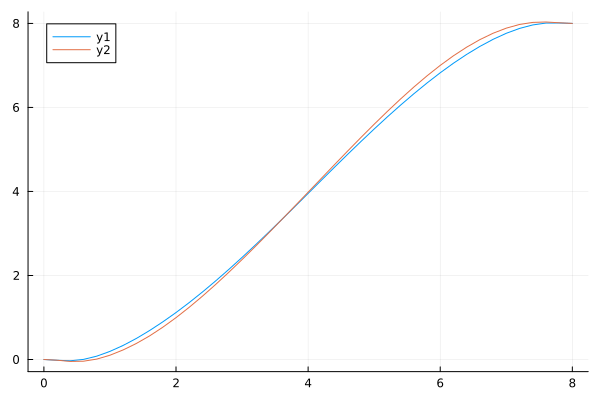

In [22]:
plot(thist,Xm[1,:])
plot!(thist,Xm[2,:])

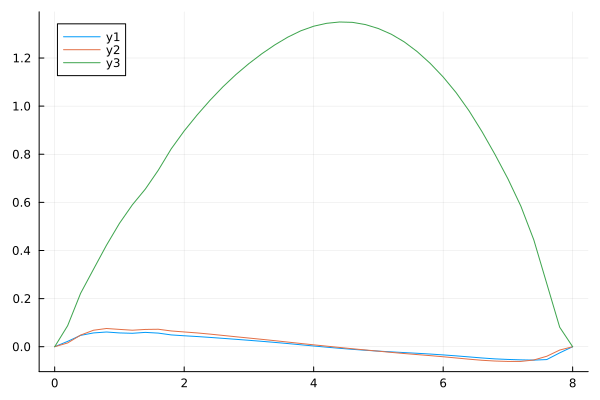

In [23]:
plot(thist,Xm[3,:])
plot!(thist,Xm[4,:])
plot!(thist,Xm[5,:])

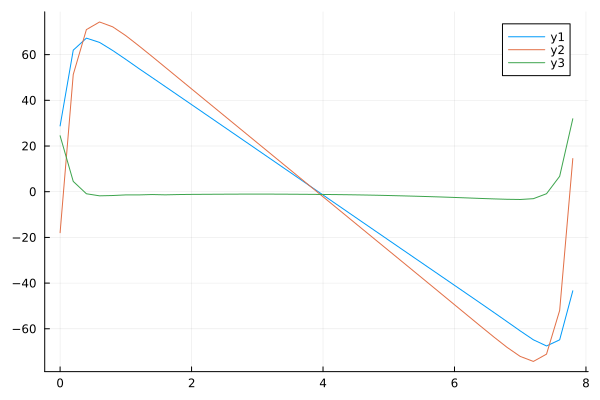

In [24]:
plot(thist[1:Nt-1],Um[1,:])
plot!(thist[1:Nt-1],Um[2,:])
plot!(thist[1:Nt-1],Um[3,:])

In [25]:
X1 = [SVector{5}(x[1:5]) for x in X];

In [26]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, thist, X1)
setanimation!(mvis, animation)

# Simulation

### TVLQR

In [28]:
Xref_trajop = FileIO.load("utils/ballbot_X_straight_arms.jld2","X_straight_arms")
Uref_trajop = FileIO.load("utils/ballbot_U_straight_arms.jld2","U_straight_arms");

In [29]:
function tvlqr(model,
               dt,
               Xbar,
               Ubar,
               Q::Matrix, # cost weight 
               R::Matrix, # cost weight 
               Qf::Matrix,# term cost weight 
               N::Int64   # horizon size 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 
        
    # check sizes of everything 
    nx = length(Xbar[1])
    nu = length(Ubar[1])
  
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)
    @assert size(Qf) == (nx, nx)
        
    # instantiate S and K 
    P = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    P[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):-1:1
        A = ForwardDiff.jacobian(x->rk4(model, x, Ubar[k], dt), Xbar[k]);
        B = ForwardDiff.jacobian(u->rk4(model, Xbar[k], u, dt), Ubar[k]);
        K[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
        P[k] = Q + A'*P[k+1]*(A-B*K[k]) 
    end
    
    return P, K 
end

tvlqr (generic function with 1 method)

In [58]:
_, K_tvlqr = tvlqr(ballbot_model, h, Xref_trajop, Uref_trajop, Q, R, Qf, Nt);

In [59]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(Xsim[i] - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [60]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

7×40 Matrix{Float64}:
  28.7819   61.5327   67.2837    65.7119   …  -67.5342    -64.8374   -43.3741
 -17.9432   51.0789   71.545     74.3824      -71.1149    -51.9732    14.5036
  24.4922    4.52144  -0.934784  -1.78669      -0.883029    6.74861   31.933
 -37.9088  -15.0391   -7.92043   -4.08173      -0.266191    6.84228   21.8101
  24.0242    9.07175   0.628139   1.75382      -2.47337   -10.6931   -23.6892
 -29.5925   -4.37077   5.11962    5.51633  …    2.6681      7.00092   21.2366
  24.2818    3.67805   1.18457   -3.40368      -0.919175   -6.15014  -25.0414

In [61]:
Xm = hcat(Xref_trajop...)
Um = hcat(Uref_trajop...);

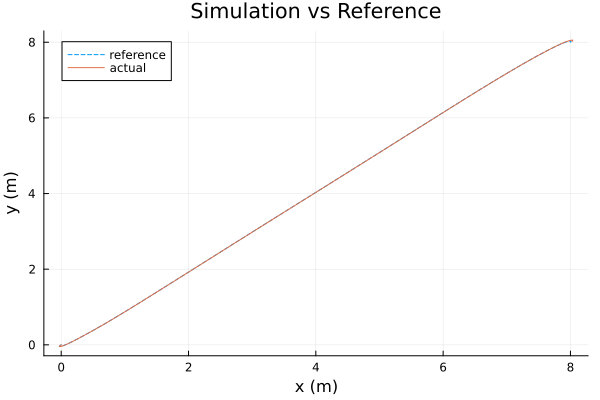

In [62]:
plot(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
display(plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual"))

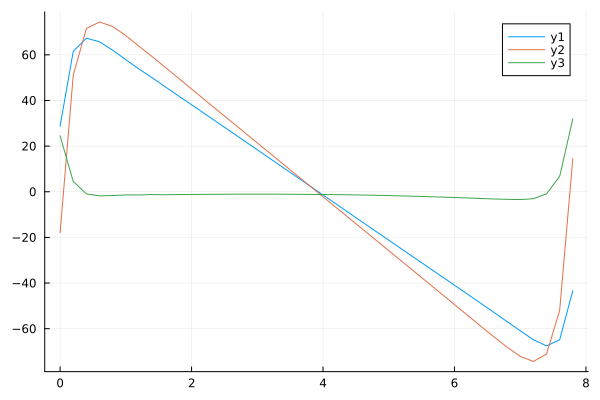

In [63]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot!(thist[1:Nt-1],Um_sim[2,:])
plot!(thist[1:Nt-1],Um_sim[3,:])

In [64]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    x_estimated = Xsim[i]*1
    x_estimated[1:2] .= x_estimated[1:2] + 0.005*randn(2)
    x_estimated[10:11] .= x_estimated[10:11] + 0.005*randn(2)
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(x_estimated - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_real_model, x_estimated, Usim[i], h)
end

In [65]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

7×40 Matrix{Float64}:
  28.7901   61.5514   67.3025    65.706    …  -67.5355    -64.8323   -43.3694
 -17.9468   51.1135   71.6075    74.4743      -71.1098    -51.9683    14.5051
  24.5069    4.52945  -0.932704  -1.78867      -0.885309    6.7463    31.931
 -37.9268  -15.0522   -7.92327   -4.06957      -0.263893    6.84638   21.809
  24.0246    9.07453   0.617228   1.75259      -2.47528   -10.6969   -23.6871
 -29.5921   -4.37009   5.12482    5.50847  …    2.67103     7.00757   21.2477
  24.2913    3.68125   1.18649   -3.40391      -0.922047   -6.15648  -25.0531

In [66]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    x_estimated = Xsim[i]*1
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(x_estimated - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, x_estimated, Usim[i], h)
end

In [67]:
Xc_sim = hcat(Xsim...)
Uc_sim = hcat(Usim...)

7×40 Matrix{Float64}:
  28.7819   61.5327   67.2837    65.7119   …  -67.5342    -64.8374   -43.3741
 -17.9432   51.0789   71.545     74.3824      -71.1149    -51.9732    14.5036
  24.4922    4.52144  -0.934784  -1.78669      -0.883029    6.74861   31.933
 -37.9088  -15.0391   -7.92043   -4.08173      -0.266191    6.84228   21.8101
  24.0242    9.07175   0.628139   1.75382      -2.47337   -10.6931   -23.6892
 -29.5925   -4.37077   5.11962    5.51633  …    2.6681      7.00092   21.2366
  24.2818    3.67805   1.18457   -3.40368      -0.919175   -6.15014  -25.0414

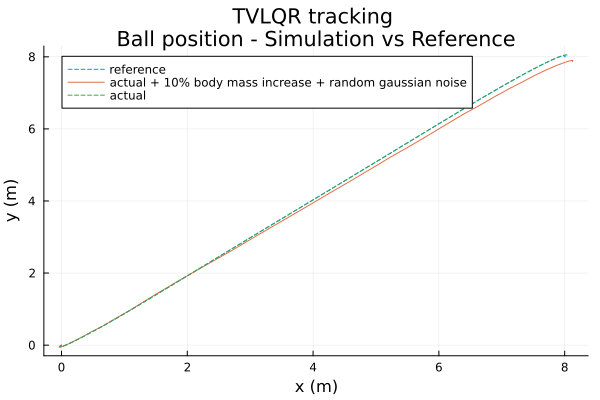

In [68]:
plot(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "TVLQR tracking \n Ball position - Simulation vs Reference ")
plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual + 10% body mass increase + random gaussian noise")
display(plot!(Xc_sim[1,:], Xc_sim[2,:], ls = :dash, label = "actual"))

In [69]:
error_x = Xm[1,:] - Xc_sim[1,:]
error_y = Xm[2,:] - Xc_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

0.015490905414142515

In [70]:
error_x = Xm[1,:] - Xm_sim[1,:]
error_y = Xm[2,:] - Xm_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

0.0814373662762907

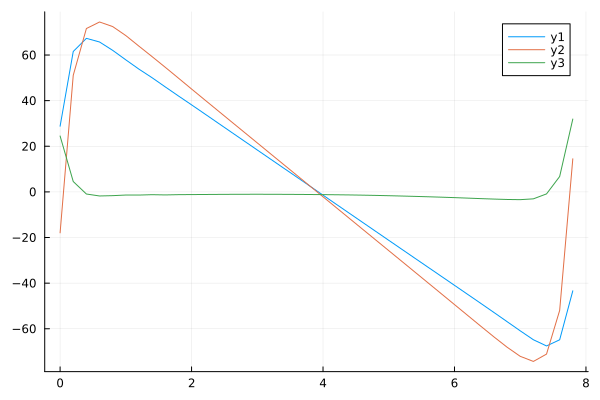

In [71]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot!(thist[1:Nt-1],Um_sim[2,:])
plot!(thist[1:Nt-1],Um_sim[3,:])

In [72]:
Xs = [SVector{5}(x[1:5]) for x in Xsim];

In [73]:
function vis_traj!(vis, name, X1; R = 0.1, color_1 = mc.RGBA(0.0, 1.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    
    for i = 1:length(X1)
        a = [X1[i][2]; -X1[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[:traj_ori]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color_1))
    end
end

vis_traj! (generic function with 1 method)

In [74]:
vis_traj!(mvis, :traj, Xref_trajop; R = 0.05, color_1 = mc.RGBA(0.0, 1.0, 0.0, 1.0))

In [75]:
Xs = [SVector{9}(x[1:9]) for x in Xsim];

In [76]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, thist, Xs)
setanimation!(mvis, animation)

# Infinity-shape

In [77]:
function create_infinity_shape_traj_t(t, i)
    scale = 10 ./ (3 .- cos.(2*t./i))
    x = scale.*cos.(t./i)
    y = scale.*sin.(2*t./i)/ 2
    return x, y
end

create_infinity_shape_traj_t (generic function with 1 method)

In [78]:
# Optimization Parameters
h = 1/3 #3 Hz
#h = 1/3
nq = 9
nx = nq*2     # number of state
nu = nq-2     # number of controls
Tfinal = 25 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*100 # position cost
diagq[3:4] = diagq[3:4]*10# lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 100*Q
R = 0.1*diagm(ones(nu))

# indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [79]:
x, y = create_infinity_shape_traj_t(thist, 3.99); #2.4

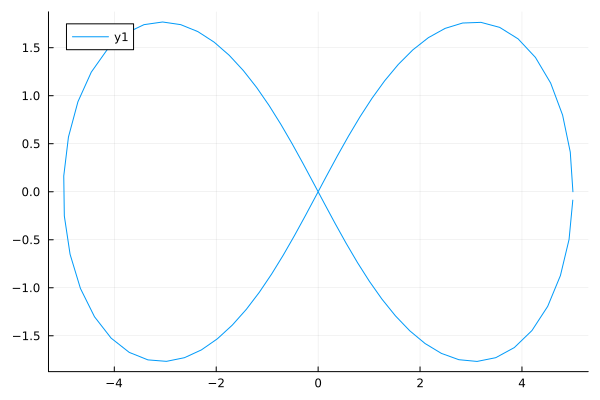

In [80]:
plot(x, y)

In [81]:
# Create warm start trajectory
Xref = [[x[i]; y[i]; zeros(nx-2)] for i = 1:Nt]
Uref = [zeros(nu) for i = 1:(Nt-1)];

In [82]:
xic =  Xref[1]
xg = Xref[end];

In [83]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf);

In [84]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= state_l
    x_u[idx.x[i]] .= state_u
    x_l[idx.u[i]] .= control_l
    x_u[idx.u[i]] .= control_u
end

x_l[idx.x[end]] .= state_l
x_u[idx.x[end]] .= state_u

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [85]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [240]:
# Uncomment to run optimization
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:  2623698
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1893
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1893
                     variables with only upper bounds:        0
Total number of equality constraints.

LoadError: InterruptException:

In [172]:
#FileIO.save("utils/ballbot_Xref_arms_8_small.jld2","Xref_arms_8_small", X)
#FileIO.save("utils/ballbot_Uref_arms_8_small.jld2","Uref__arms_8_small", U)

In [86]:
Xref_trajop = FileIO.load("utils/ballbot_Xref_arms_8.jld2","Xref_arms_8")
Uref_trajop = FileIO.load("utils/ballbot_Uref_arms_8.jld2","Uref__arms_8");

In [87]:
Xm = hcat(Xref_trajop...)
Um = hcat(Uref_trajop...);

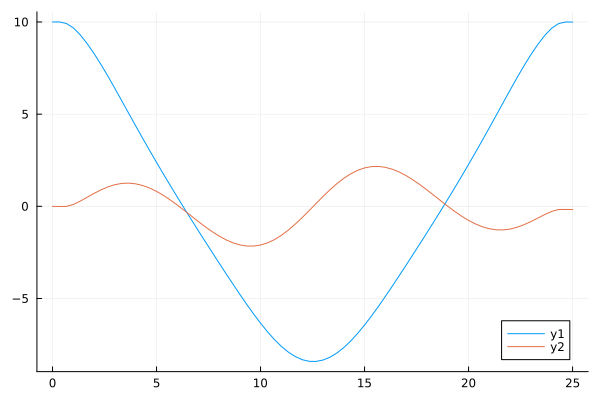

In [88]:
plot(thist,Xm[1,:])
plot!(thist,Xm[2,:])

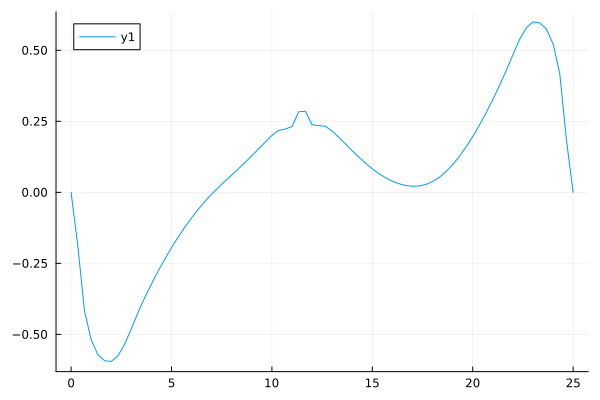

In [89]:
plot(thist,Xm[5,:])

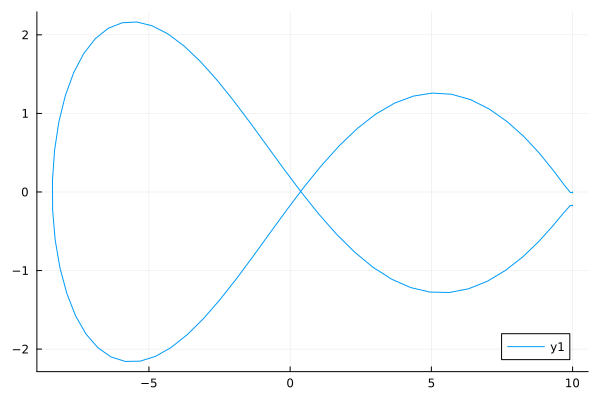

In [90]:
plot(Xm[1,:],Xm[2,:])

In [92]:
_, K_tvlqr = tvlqr(ballbot_model, h, Xref_trajop, Uref_trajop, Q, R, Qf, Nt);

In [93]:
x0 = Xref_trajop[1]

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(Xsim[i] - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [94]:
Xc_sim = hcat(Xsim...)
Uc_sim = hcat(Usim...)

7×75 Matrix{Float64}:
 -73.6024   -91.9024    -91.2734   …  -88.3108   -96.2173   -67.6483
   4.65288   66.5388     55.4983      -43.1586   -57.945     -5.39996
 -23.2103     8.0937      7.2123       -6.47308   -6.60746   23.1927
  45.4498    11.4059      2.0424        4.28058    6.96055   33.7759
 -34.0622    -9.38824    -2.98413      -6.56725   -9.76417  -43.8523
  38.6662    -0.494677  -10.224    …   -2.1022     2.2919    26.6158
 -29.4866    -5.64318     6.74708       5.55085    2.59407  -35.6086

In [95]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    x_estimated = Xsim[i]*1
    x_estimated[1:2] .= x_estimated[1:2] + 0.005*randn(2)
    x_estimated[10:11] .= x_estimated[10:11] + 0.005*randn(2)
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(x_estimated - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_real_model, x_estimated, Usim[i], h)
end

In [96]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

7×75 Matrix{Float64}:
 -73.4959   -91.8327    -91.3046   …  -88.8372   -96.9666   -68.0455
   4.68369   66.7713     56.1652      -43.3282   -57.4805    -6.6937
 -23.2497     7.88818     7.35099      -6.41663   -6.76417   23.2635
  45.4525    11.5643      1.88213       4.42512    6.88891   33.9428
 -34.0297    -9.38187    -2.83663      -6.76554   -9.74911  -44.0908
  38.6192    -0.405586  -10.3483   …   -1.95795    2.23264   26.7931
 -29.4191    -5.79631     6.82873       5.3864     2.64326  -35.8264

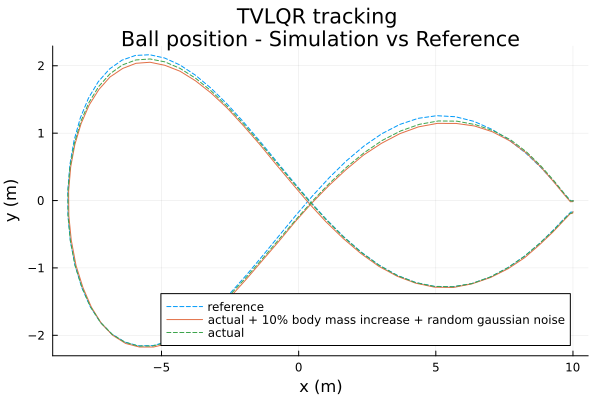

In [97]:
plot(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "TVLQR tracking \n Ball position - Simulation vs Reference ")
plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual + 10% body mass increase + random gaussian noise")
display(plot!(Xc_sim[1,:], Xc_sim[2,:], ls = :dash, label = "actual"))

In [98]:
error_x = Xm[1,:] - Xc_sim[1,:]
error_y = Xm[2,:] - Xc_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

0.03323069867979391

In [99]:
error_x = Xm[1,:] - Xm_sim[1,:]
error_y = Xm[2,:] - Xm_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

0.05553412033215759

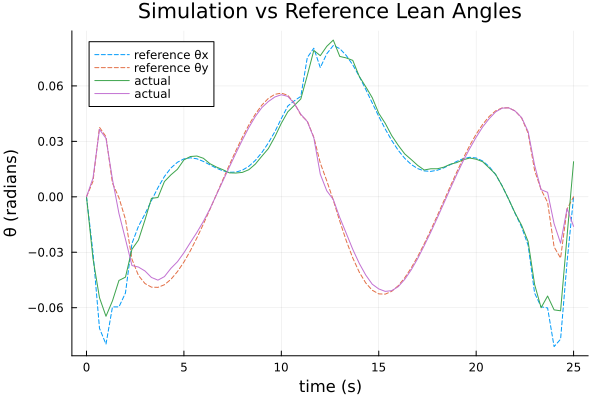

In [101]:
plot(thist, Xm[3,:], ls = :dash, label = "reference θx",
         xlabel = "time (s)", ylabel = "θ (radians)", title = "Simulation vs Reference Lean Angles")
plot!(thist, Xm[4,:], ls = :dash, label = "reference θy")
plot!(thist, Xm_sim[3,:], label = "actual")
display(plot!(thist, Xm_sim[4,:], label = "actual"))

In [226]:
function vis_traj!(vis, name, X1; R = 0.1, color_1 = mc.RGBA(1.0, 0.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    for i = 1:length(X1)
        a = [X1[i][2]; -X1[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[:traj_ori]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color_1))
    end
end

vis_traj! (generic function with 2 methods)

In [103]:
vis_traj!(mvis, :traj, Xref_trajop; R = 0.05, color_1 = mc.RGBA(0.0, 1.0, 0.0, 1.0))

In [104]:
Xs = [SVector{9}(x[1:9]) for x in Xsim];

In [106]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, thist, Xs)
setanimation!(mvis, animation)

In [107]:
display(render(mvis))

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj_ori" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s53" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x35, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s11" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x31, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x6a, 0x5f, 0x6f, 0x72, 0x69, 0x2f, 0x73, 0x31, 0x35], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Xtran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x58, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Ytran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x59, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Pitch" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72